# ARIMA and Rolling Forecast

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Month 칼럼을 읽기 위한 파서
def dateparser(x):
    return datetime.strptime('190'+x, "%Y-%m")
#    "1-01" => "1901-01"

shampoo = pd.read_csv('tsa_data/sales-of-shampoo.csv', index_col='Month', parse_dates=True, date_parser=dateparser)
print(shampoo.shape)
shampoo.head()

(36, 1)


,Sales of shampoo
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


## Visualize the data

pandas 내장 플로팅 함수들로 시계열 데이터를 시각화 해봅니다. **뚜렷한 트랜드를 보이는 반면 시즌 패턴은 보이지 않습니다.**

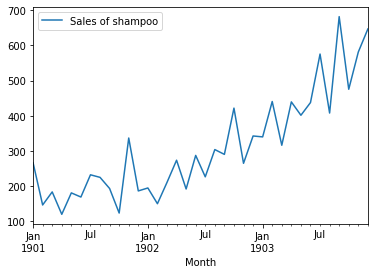

In [5]:
shampoo.plot()

In [6]:
## Testing for Stationarity
from statsmodels.tsa.stattools import adfuller

# 현재 데이터 상태가 Stationarity 한지 체크
# Stationarity에 대한 check
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-Stationary {}'.format(result[1]))
        
adf_check(shampoo['Sales of shampoo'])

################ => 테스트 결과 데이터가 stationary 특성을 보이지 않고 있음이 확인됩니다.

## Differencing 진행 필요.

Non-Stationary 1.0


## Differencing

- 시계열 데이터에 대한 1차(first) difference 는 다음 스탭으로의 한 차원(시간단위) 만큼의 변화값의 series 입니다. pandas 를 이용하면 아주 differencing 할 수 있습니다. **1차, 2차 등 differencing 을 시도해보고 stationary 한 차원을 찾습니다.**

### First Difference

Stationary 1.7998574141687034e-10


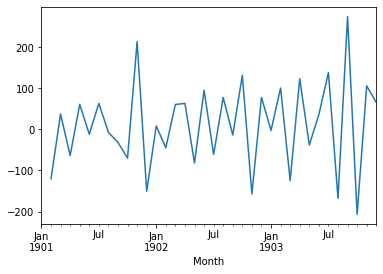

In [7]:
# 1차 diff
shampoo['1st diff'] = shampoo['Sales of shampoo'] - shampoo['Sales of shampoo'].shift(1)

adf_check(shampoo['1st diff'].dropna())

shampoo['1st diff'].plot()

- 수치상으로는 Stationarity 하다고 나온다.
- **그림상으로 Mean은 일정해 보이는데, 분산은 조금 갑자기 커지는 부분이 있어서 한번더 진행해보기로 함.**

### Second Difference

Stationary 0.0039063349396599245


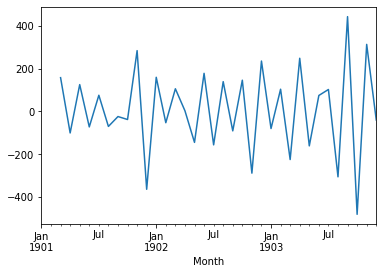

In [8]:
# Second Dfiierence
shampoo['2nd diff'] = shampoo['1st diff'] - shampoo['1st diff'].shift()

# Stationarty 체크 함수
adf_check(shampoo['2nd diff'].dropna())

shampoo['2nd diff'].plot()

- AutoCorrelation 하고 Partial Autocorrelation 으로 체크
- Grid Search 를 통해서 하이퍼 파라미터 찾기로 함.
- **Seasonilty 모델이 안보이기 때문에 그냥 ARIMA 모델 쓰기로 함.**

## Autocorrelation and Partial Autocorrelation Plots

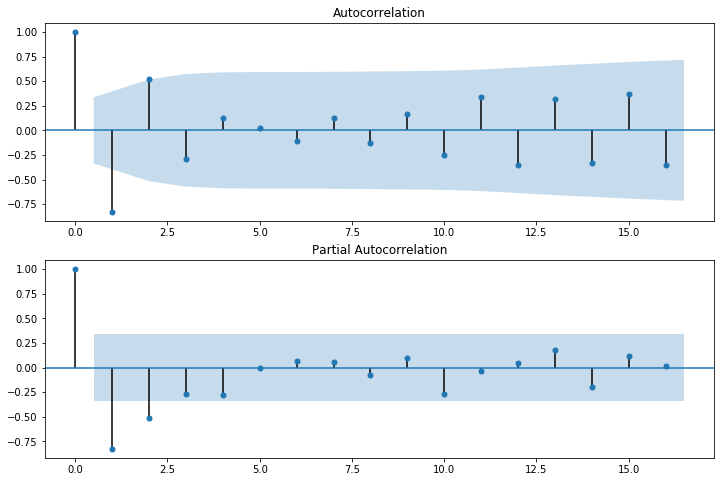

In [9]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(shampoo['2nd diff'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(shampoo['2nd diff'].dropna(), ax=ax2, method='ywm')

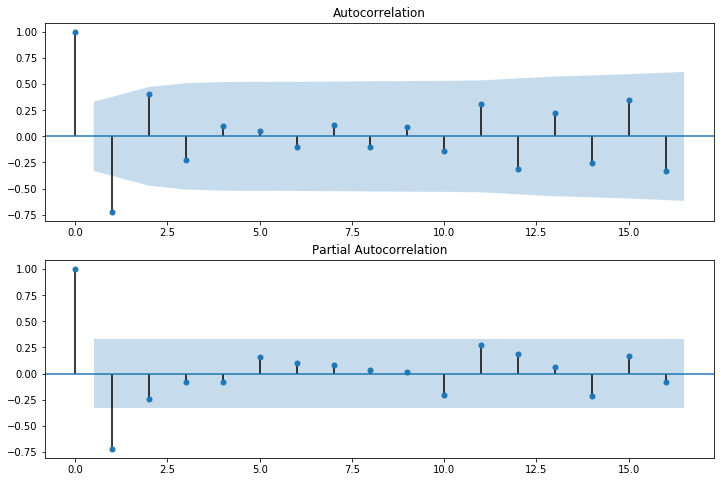

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(shampoo['1st diff'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(shampoo['1st diff'].dropna(), ax=ax2, method='ywm')

- **PACF 와 ACF 에서 각각 lag 1 에 대해 강한 상관관계를 보이고 있습니다.**

In [11]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(shampoo['Sales of shampoo'], order=(1,1,1), freq='MS')
model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.Sales of shampoo   No. Observations:                   35
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -197.233
Method:                       css-mle   S.D. of innovations             66.625
Date:                Sat, 13 Jun 2020   AIC                            402.467
Time:                        18:36:56   BIC                            408.688
Sample:                    02-01-1901   HQIC                           404.614
                         - 12-01-1903                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       12.0965      3.651      3.313      0.001       4.940      19.253
ar.L1.D.Sales of shampoo    -0.5674      0.161     -3.526      0.000      -0.883      -0.

- **일단 residual error 에 대해 line plot 을 그려고보 모델에 의해 파악되지 않은 트랜드 정보가 있는지 확인**

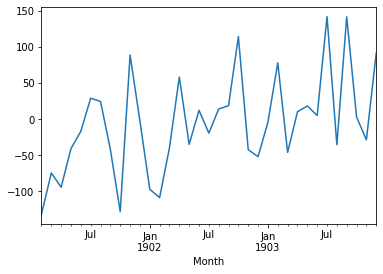

In [12]:
# plot residual errors
model_fit.resid.plot()

- **다음으로 residual error 에 대한 density plot 을 그리고 정규분포에 가까운지 확인합니다.**

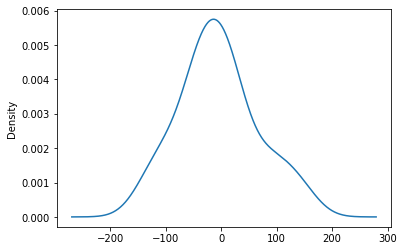

In [14]:
# residual 에 대한 가우시안 분포 확인 
model_fit.resid.plot(kind='kde')

- **어느정도 잘 나오는 것을 알수 있음 0을 기준으로 bias없이**

## GridSearch
AIC 를 기준으로 최적의 p,d,q 파라메터를 찾습니다.

In [17]:
import itertools

p = range(0,5)
d = range(1,3)
q = range(0,5)

pdq = list(itertools.product(p, d, q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 2, 0),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4)]

In [20]:
# 각 pdq마다 훈련해서 제일 좋은 걸 찾음.
aic_params = []

for param in pdq:
    try:
        mod = ARIMA(shampoo['Sales of shampoo'], order=param)
        results = mod.fit(disp=0)
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        aic_params.append((results.aic, param,))
    except:
        pass

ARIMA(0, 1, 0) - AIC:430.87311187552797
ARIMA(0, 1, 1) - AIC:409.01266224109315
ARIMA(0, 1, 2) - AIC:399.60626117482946
ARIMA(0, 1, 3) - AIC:401.5384453920783
ARIMA(0, 1, 4) - AIC:403.16610657583044
ARIMA(0, 2, 0) - AIC:461.1578257086931
ARIMA(0, 2, 1) - AIC:424.58251536560675
ARIMA(1, 1, 0) - AIC:406.02228959235015
ARIMA(1, 1, 1) - AIC:402.46665241800315
ARIMA(1, 1, 2) - AIC:401.5247943798388
ARIMA(1, 1, 3) - AIC:403.5241728752876
ARIMA(1, 2, 0) - AIC:423.9000860378365
ARIMA(2, 1, 0) - AIC:403.62756411659745
ARIMA(2, 1, 1) - AIC:404.28621423308175
ARIMA(2, 2, 0) - AIC:412.999382497202
ARIMA(2, 2, 1) - AIC:396.65262552744326
ARIMA(2, 2, 3) - AIC:389.6835119493725
ARIMA(3, 1, 0) - AIC:404.6924591819578
ARIMA(3, 1, 1) - AIC:406.1395443929737
ARIMA(3, 1, 4) - AIC:406.6797907848709
ARIMA(3, 2, 0) - AIC:410.9109265845837
ARIMA(3, 2, 1) - AIC:396.3062365835437
ARIMA(3, 2, 3) - AIC:406.1049294516404
ARIMA(4, 1, 0) - AIC:404.78676855670403
ARIMA(4, 1, 1) - AIC:406.57964036120745
ARIMA(4, 1, 2)

In [21]:
# ARIMA(4,2,1) ==> 421이 제일 좋은 경우
model = ARIMA(shampoo['Sales of shampoo'], order=(4,2,1)) # 파라미터 여러번 바꿔봐야함
results = model.fit()
print(results.summary())

                              ARIMA Model Results                              
Dep. Variable:     D2.Sales of shampoo   No. Observations:                   34
Model:                  ARIMA(4, 2, 1)   Log Likelihood                -189.577
Method:                        css-mle   S.D. of innovations             56.216
Date:                 Sat, 13 Jun 2020   AIC                            393.154
Time:                         18:39:54   BIC                            403.839
Sample:                     03-01-1901   HQIC                           396.798
                          - 12-01-1903                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.8979      0.246      3.654      0.000       0.416       1.380
ar.L1.D2.Sales of shampoo    -1.2964      0.161     -8.036      0.000      -1.

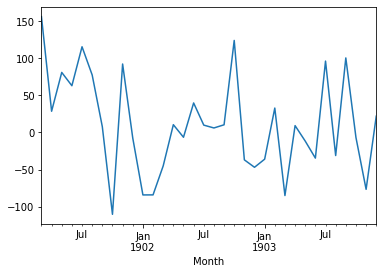

In [22]:
# 다시 residual에 대한 그래프 출력
results.resid.plot()

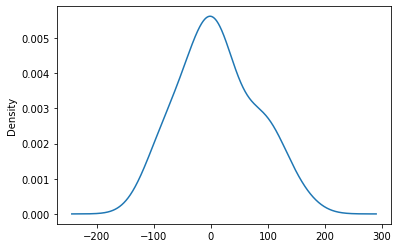

In [24]:
# 똑같이 정규분포로 잘 모양을 띄고 있음
results.resid.plot(kind='kde')

## Rolling Forecast ARIMA Model

- ARIMA 모델로 미래 데이터를 예측하기 위해 predict() 함수를 사용합니다. 이 함수는 파라메터로 예측할 타임스텝을(steps) 필요로하는데 학습 데이터에대한 인덱스 상대값을 입력하면 됩니다. 
- 가령 모델을 학습하기 위해 100개의 학습데이터를 사용했다면 다음 스텝 예측값의 인덱스는 start=101, end=101 이 됩니다. 예측 결과 리턴값은 하나의 예측값을 포함한 배열이 됩니다.
- 또는 forcast() 함수로 파라메터 없이 다음 한 스템의 데이터를 예측할 수 있습니다.
- 데이터를 train 과 test 로 나눈 뒤 train 데이터로 모델을 학습시키고 test 데이터의 각 시점에 해당하는 예측 해봅니다. 그러기 위해 새로운 actual value 를 하나씩 수집하면서 그와 함께 앞선 시점의 데이터로 ARIMA 모델을 학습과 예측을 반복하는 rolling forecast 를 수행하게 됩니다.
- 아래 코드에서 수동으로 관측값을을 history 변수에 추가해가면서 모델링과 예측을 반복하면서 prediction 과 expected value 를 출력하고 최종적으로 그에 따른 mean squared error (MSE) 를 계산합니다.

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = shampoo['Sales of shampoo'].values

# train , test 데이터를 2:1 로 split
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

# 학습시킬 데이터
history = [x for x in train]
predictions = list()

# test 데이터만큼 모델링 & 예측
for t in range(len(test))
:
    # 다음 step까지만 test
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast() 
    
    # predicted value - predictions에 다 모으는 것. append
    yhat = output[0]
    predictions.append(yhat)
    
    # actual value
    obs = test[t]
    
    # actual value 를 다음 스텝에서 학습할 데이터에 추가
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % sqrt(error))

predicted=399.145026, expected=342.300000
predicted=354.296620, expected=339.700000
predicted=429.967852, expected=440.400000
predicted=392.634668, expected=315.900000
predicted=420.191752, expected=439.300000
predicted=397.585212, expected=401.300000
predicted=487.892659, expected=437.400000
predicted=434.160100, expected=575.500000
predicted=467.057751, expected=407.600000
predicted=568.082692, expected=682.000000
predicted=468.024713, expected=475.300000
predicted=687.491463, expected=581.300000
predicted=617.839202, expected=646.900000
Test RMSE: 68.519


In [27]:
shampoo['Sales of shampoo'].describe()

# 약 std의 절반만큼 에러가 나는 것 -> 쩃든 성능이 그렇게 좋은 편은 아니..ㄴ

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales of shampoo, dtype: float64

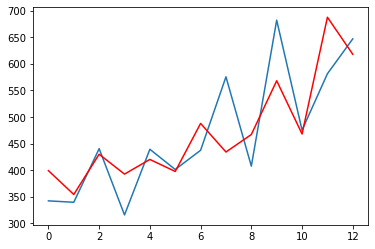

In [26]:
plt.plot(test)
plt.plot(predictions, color='red')

- **실제값(파란색)과 rolling forecast(red) 결과를 비교해보면 트렌드를 어느정도 예측하고 있음을 확인할 수 있습니다.**
- 성능은 좀 실패....